In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [2]:
# Step 1: Load Data
balancing_df = pd.read_csv("balancing_data.csv",
                           parse_dates=["GMT Time"],
                           na_values=['No Data Available']
                           )
balancing_df.columns = ["Time",
                        "System Price",
                        "NIV Outturn",
                        "BM Bid Acceptances",
                        "BM Offer Acceptances",
                        "BSAD Volume Turn Up",
                        "BSAD Volume Turn Down",
                        "BSAD Volume Total",
                        "Intraday Volume"]

In [3]:
df = balancing_df.interpolate(method='linear')

In [4]:
natural_gas_price_uk = pd.read_csv("markets_historical_nguk_com.csv", parse_dates=["Date"], dayfirst=True)
natural_gas_price_uk = natural_gas_price_uk.sort_values(by="Date", ascending=True).drop(columns=['Symbol']).set_index("Date")   

In [5]:
first_row = natural_gas_price_uk.iloc[0]
new_index = pd.to_datetime('2018-01-01 00:00:00')
natural_gas_price_uk.loc[new_index] = first_row
natural_gas_price_uk.sort_index(inplace=True)

In [6]:
natural_gas_price_uk = natural_gas_price_uk.reindex(balancing_df.set_index('Time').index, method='ffill')

In [7]:
natural_gas_price_uk = natural_gas_price_uk.reset_index()
natural_gas_price_uk = natural_gas_price_uk.rename(columns={'index': 'Time'})

In [8]:
df = df.merge(natural_gas_price_uk, on='Time')

In [9]:
df = df[df["Time"] >= "2024-06-01"]

<Axes: xlabel='Time'>

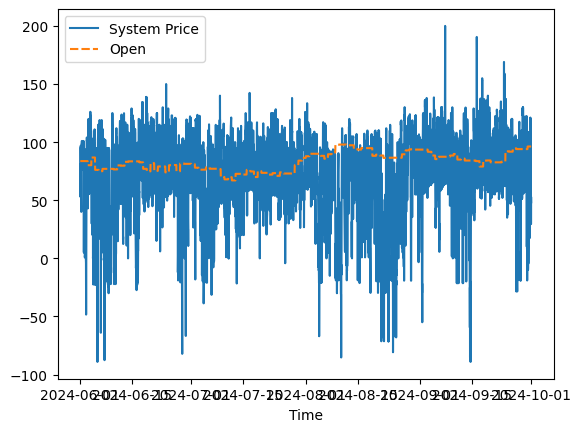

In [14]:
sns.lineplot(data=df[["System Price","Open"]].set_index(df["Time"]))

In [37]:
# Step 3: Split Data
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [38]:
# # Step 4: Stationarity Test
def adf_test(series, title=''):
    print(f'ADF Test: {title}')
    result = adfuller(series)
    labels = ['ADF Statistic','p-value','#Lags Used','Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out)
    if result[1] <= 0.05:
        print("Stationary")
    else:
        print("Non-Stationary")

adf_test(train['System Price'], 'System Price')
adf_test(train['High'], 'High Price')

ADF Test: System Price
ADF Statistic                 -1.029932e+01
p-value                        3.404882e-18
#Lags Used                     4.600000e+01
Number of Observations Used    2.103400e+04
Critical Value (1%)           -3.430661e+00
Critical Value (5%)           -2.861677e+00
Critical Value (10%)          -2.566843e+00
dtype: float64
Stationary
ADF Test: High Price
ADF Statistic                     -2.754827
p-value                            0.065022
#Lags Used                         0.000000
Number of Observations Used    21080.000000
Critical Value (1%)               -3.430660
Critical Value (5%)               -2.861677
Critical Value (10%)              -2.566843
dtype: float64
Non-Stationary


In [43]:
# # Step 5: Differencing
train_diff = train['System Price'].diff().dropna()
adf_test(train_diff, 'y Differenced')

ADF Test: y Differenced
ADF Statistic                    -40.143001
p-value                            0.000000
#Lags Used                        46.000000
Number of Observations Used    21033.000000
Critical Value (1%)               -3.430661
Critical Value (5%)               -2.861677
Critical Value (10%)              -2.566843
dtype: float64
Stationary


In [45]:
train_diff

91969     14.81
91970     -8.25
91971     -1.56
91972      0.56
91973     -0.56
          ...  
113044    11.00
113045    -7.06
113046     0.06
113047     0.00
113048     0.00
Name: System Price, Length: 21080, dtype: float64

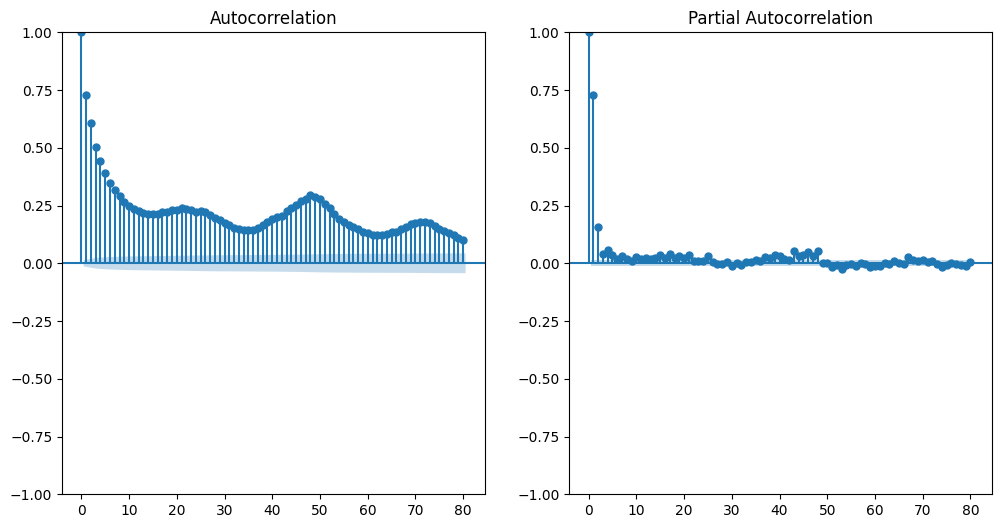

In [ ]:
# # Step 6: ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(train['System Price'], ax=plt.gca(), lags=80)
plt.subplot(122)
plot_pacf(train['System Price'], ax=plt.gca(), lags=80)
plt.show()

In [48]:
# First-order differencing
df['y_diff1'] = df['System Price'].diff().dropna()

# Seasonal differencing (e.g., seasonality=48)
df['y_diff_seasonal'] = df['y_diff1'].diff(48).dropna()

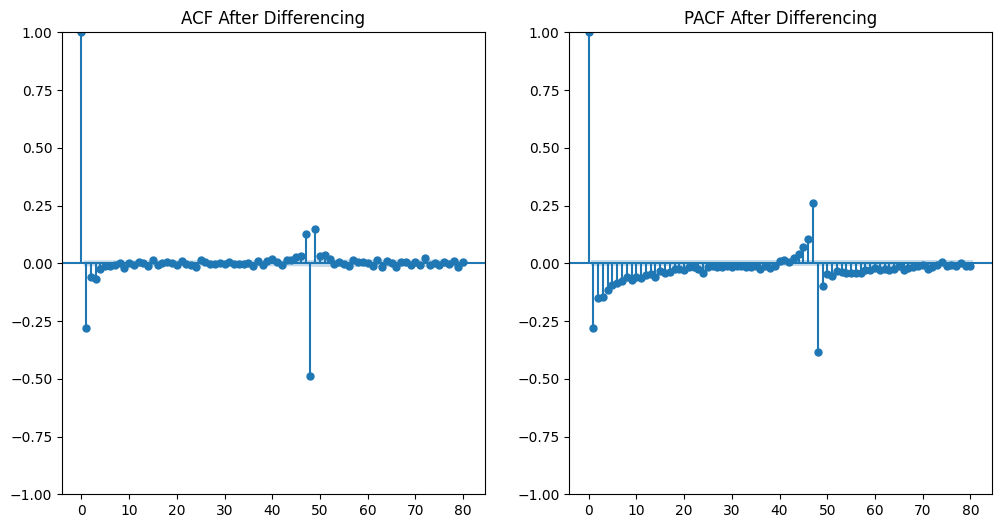

In [50]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(df['y_diff_seasonal'].dropna(), ax=plt.gca(), lags=80)
plt.title('ACF After Differencing')

plt.subplot(122)
plot_pacf(df['y_diff_seasonal'].dropna(), ax=plt.gca(), lags=80)
plt.title('PACF After Differencing')
plt.show()

In [51]:
# # Assume p=1, d=1, q=1; P=1, D=1, Q=1, s=48
# # Step 7 & 8: Fit SARIMAX
model = SARIMAX(
    train['System Price'],
    exog=train['High'],
    order=(1,1,1),
    seasonal_order=(1,1,1,48),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_model = model.fit(disp=False)
print(sarimax_model.summary())

: 